#  Arquivo fonte para experimento de Fading

### Importando Bibliotecas

In [1]:
import csv
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def momentEstimator(moment,data):
    mi = 0
    for x in range(len(data)):
        mi = mi + h[x]**moment
    return ((1/len(data))*mi)    

### Dados gerados no smartRF

In [5]:
'''
LEIA IMPORTANTE!
    Caminho para arquivo gerado no SmartRF. Esse arquivo contêm informações das mensagens que foram recebidas.
'''
received_rx = 'data/sample2.txt'

# Modelagem do *Fading*

### Criação do dataset

In [6]:
# Criação do o dados do Receptor usando arquivo gerado pelo SmartRF
df_rx = pd.read_csv(received_rx, sep="|", header = None)
df_rx.columns = ["timestamp","# of packets","index","packets","power_raw"]
def check_if_error(s):
    if "error" in s:
        return True
    else:
        return False
    
#Limpa os dados da coluna power, para pegar só o valor númerico
try:
    df_rx['power'] = df_rx["power_raw"].apply(lambda x: x[0:6].strip())
    df_rx["error?"] = df_rx['power_raw'].apply(lambda x: check_if_error(x))
    df_rx = df_rx.drop("power_raw",axis=1)
except:
    df_rx['power'] = df_rx["power_raw"]
    df_rx = df_rx.drop("power_raw",axis=1)


### Plotando RSSI Instantânea

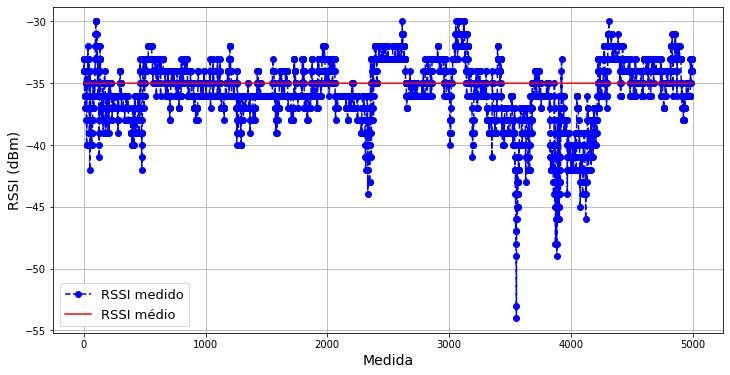

In [7]:
import math
seq = np.arange(0, len(df_rx), 1)
RSSI = df_rx.power
RSSI=RSSI.astype(float)
rssi_medio = []
rssi_linear = []
rssi_medio_linear = []
for x in range(len(seq)):
    rssi_linear.append((10**(RSSI[x]/10)))    
rssi_medio_linear = np.mean(rssi_linear)
rssi_m = math.log10(rssi_medio_linear)*10

for x in range(len(seq)):
    rssi_medio.append(rssi_m)
    
plt.figure(figsize=(12,6))

plt.plot(seq, RSSI, 'bo--', label=u'RSSI medido')
plt.plot(seq, rssi_medio, 'r-', label=u'RSSI médio')

plt.legend(loc=u'lower left', fontsize=13)
plt.xlabel(u'Medida', fontsize=14)
plt.ylabel(u'RSSI (dBm)', fontsize=14)
plt.grid(1)
plt.savefig('medidasrssi.PNG',dpi=1200)

### Calculando Fading (hi)

In [8]:
h2 = []

for x in range(len(seq)):
    h2.append(rssi_linear[x] / rssi_medio_linear)

h = np.sqrt(h2)

### Distribuição de h^2

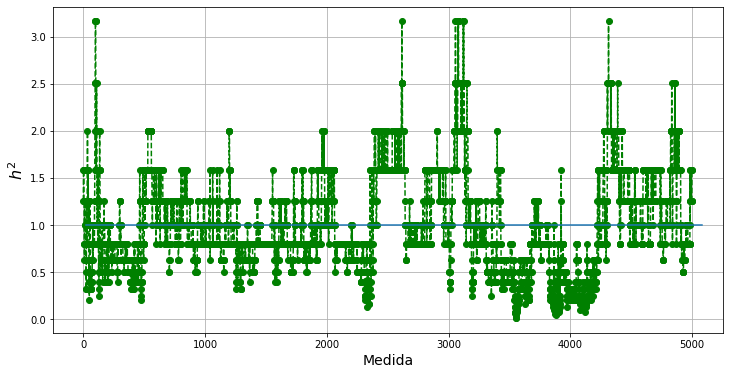

In [9]:
plt.figure(figsize=(12,6))

plt.plot(seq, h2, 'go--')
plt.axhline(y=1, xmin=0.05, xmax=.97)

plt.xlabel('Medida', fontsize=14)
plt.ylabel('$h^2$', fontsize=16)
plt.grid(1)

###  Pdf da dristribuição de Rayleigh

In [10]:
from scipy.stats import nakagami, rayleigh
from scipy.special import gamma

param = rayleigh.fit(h)
print (param)
dist = rayleigh.pdf(h, loc=param[0], scale=param[1])

(0.11192700749038452, 0.6308837514449133)


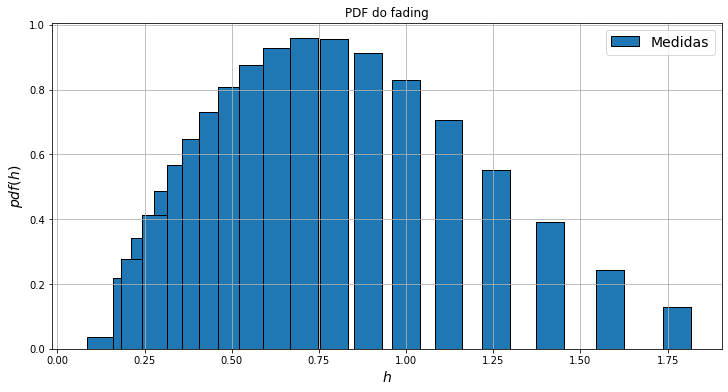

In [11]:
plt.figure(figsize=(12,6))

plt.bar(h, dist, label=u'Medidas', edgecolor=['black'], width=.08)

plt.legend(loc=u'upper right', fontsize=14)
plt.title(u'PDF do fading')
plt.xlabel(u'$h$', fontsize=14)
plt.ylabel(u'$pdf(h)$', fontsize=14)
plt.grid(1)

### Estimando m de nakagami-m

In [12]:
p=100
moment1DividedByp = momentEstimator((1/p),h)
momentIs2= momentEstimator(2,h)
moment2Plus1DividedByP= momentEstimator((2+(1/p)),h)
estimated = float((moment1DividedByp*momentIs2)/(2*p*(moment2Plus1DividedByP-(moment1DividedByp*momentIs2))))
print('m estimado é',  estimated)
param = nakagami.fit(h)
print("m calculado pelo scipy é",param[0])

m estimado é 3.6716071112972797
m calculado pelo scipy é 17.646119863370057


### Histograma das medições e a pdf ajustada da distribuição Nakagami-m (vermelho)

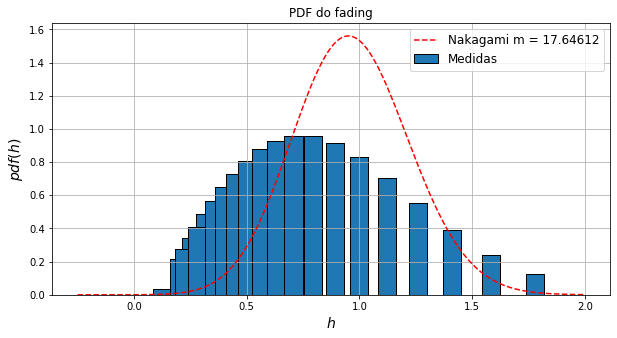

In [14]:
'''
LEIA IMPORTANTE
    Utilize m calculado pelo Scipy caso seja um valor proxímo ao estimado.
    
    m = param[0]
    
    Porém se diverge em mais de duas unidades utilize o estimado.
    
    m = estimated
    
'''

m = param[0]

plt.figure(figsize=(10,5))
plt.bar(h, dist, label=u'Medidas', edgecolor=['black'], width=.08)

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(h))
size = 1
pdf_g = nakagami.pdf(lnspc, m, loc=param[1], scale=param[2])*size  
plt.plot(lnspc, pdf_g, 'r--', label="Nakagami m = " + str(round(m, 5)))

plt.legend(loc=u'upper right', fontsize=12)
plt.title(u'PDF do fading')
plt.xlabel(u'$h$', fontsize=14)
plt.ylabel(u'$pdf(h)$', fontsize=14)
plt.grid(1)
plt.show()